In [1]:
from pymongo import MongoClient
import numpy as np
import pandas as pd
import scipy.optimize

client = MongoClient("c3.itp.ac.ru", 27027)

In [2]:
import matplotlib.pylab as plt

In [5]:
tempsdf={}
for result in client.numerics.glass.find({}):
    temp = result["T"]
    size = result["Nx"]
    if temp not in tempsdf.keys():
        tempsdf[temp] = [size]
    elif size not in tempsdf[temp]:
        tempsdf[temp].append(size)

ServerSelectionTimeoutError: c3.itp.ac.ru:27027: [WinError 10061] Подключение не установлено, т.к. конечный компьютер отверг запрос на подключение, Timeout: 30s, Topology Description: <TopologyDescription id: 624842dd09acdd167abab1c9, topology_type: Single, servers: [<ServerDescription ('c3.itp.ac.ru', 27027) server_type: Unknown, rtt: None, error=AutoReconnect('c3.itp.ac.ru:27027: [WinError 10061] Подключение не установлено, т.к. конечный компьютер отверг запрос на подключение')>]>

In [6]:
def corr_time(Nx, Ny, T, dist=0, min_time = 0, max_time = np.inf, draw_each = False, fit=False):
    mt = []
    df = pd.DataFrame()
    for result in client.numerics.glass.find({"Nx": Nx, "Ny": Ny, "T": T}):
        # flag = False
        # for el in result['corr_values']:
        #    if el < 0:
        #        flag = True
        #        break
        # if flag:
        #    continue
        
        try:
            if result['Distribution'] != dist:
                continue
        except KeyError:
            if dist != 0:
                continue
            
        x = np.array(result['corr_times'])
        y = np.array(result['corr_values'])
        
        y = y[(x[:] >= min_time) & (x[:] <= max_time)]
        x = x[(x[:] >= min_time) & (x[:] <= max_time)]

        if draw_each:
            plt.semilogy(x, y, linestyle=':')
            
        df = pd.concat([df, pd.Series(y)], axis=1)
        
    y_mean = df.mean(axis=1)
    y_err = df.std(axis=1)
    
    plt.errorbar(x, y_mean, yerr=y_err, fmt='x', label="MC - T: {}, dist: {}".format(T, dist), elinewidth=0.5)
    plt.yscale('log')
    #plt.semilogy(x, y_mean, linestyle='-.', label="Temp: {}".format(T))
    
    if fit:
        params, params_covariance = scipy.optimize.curve_fit(q_beta, x, np.log(np.array(y_mean)))
        plt.semilogy(np.linspace(x[0], x[-1], 200), qb(np.linspace(x[0], x[-1], 200), params[0], params[1], params[2]), linestyle='--', label=r"Fit - T: {}, $\beta$: {:.2f}".format(T, params[2]))
        
        print(params)
    
    plt.legend()

In [7]:
def q_line(t, tau, A):
    return A - t / tau

In [8]:
def q_beta(t, tau, A, beta):
    return A - t ** beta / tau

In [9]:
def q_beta_x(t, tau, A, beta, x):
    return A - t ** beta / tau - x * np.log(t)

In [10]:
def q(t, tau, A):
    return np.exp(A - t / tau)

In [11]:
def qb(t, tau, A, beta):
    return np.exp(A - t ** beta / tau)

In [12]:
def qbx(t, tau, A, beta, x):
    return np.exp(A - t ** beta / tau) / t ** x

In [13]:
def observables(Nx, Ny, T):
    e, m, chi, c = [], [], [], []
    for result in client.numerics.ising.find({"Nx": Nx, "Ny": Ny, "T": T}):
       #  if np.abs(result['corr_values'][-1]) >= 1e-2: continue
        e.append(result['Energy'])
        m.append(np.abs(result['Magnetization']))
        c.append(result['Energy2'])
        chi.append(result['Magnetization2'])
    return [np.mean(e), np.mean(m), np.mean(c), np.mean(chi)]

In [14]:
def observables_glass(Nx, Ny, T, dist=0):
    e, m, chi, c = [], [], [], []
    for result in client.numerics.glass.find({"Nx": Nx, "Ny": Ny, "T": T}):
       #  if np.abs(result['corr_values'][-1]) >= 1e-2: continue
    
        try:
            if result['Distribution'] != dist:
                continue
        except KeyError:
            if dist != 0:
                continue
    
        e.append(result['Energy'])
        m.append(np.abs(result['Magnetization']))
        c.append(result['Energy2'])
        chi.append(result['Magnetization2'])
    return [np.mean(e), np.mean(m), np.mean(c), np.mean(chi)]

In [15]:
plt.scatter([5.0, 4.0, 3.0, 2.0, 1.5, 1.25, 1.0, 0.9, 0.8, 0.7], [0.74264393, 0.69984329, 0.60699807, 0.51189471, 0.45075815, 0.40359176, 0.36098732, 0.34170817, 0.33704854, 0.33484607])
plt.ylabel(r'$\beta$')
plt.xlabel(r'$Temp$')

plt.axhline(1/3, linestyle='--', color='orange', linewidth=1)

NameError: name 'plt' is not defined

In [17]:
plt.figure(figsize=(16, 9), dpi=150)

dd=[0,1]

for temp in temps[-24:-21]:
    for s in tempsdf[temp]:
        for ds in dd:
            try:
                corr_time(s, s, temp, dist=ds)
            except Exception:
                continue

plt.xlabel('Time (MCS)')
plt.ylabel('<q(t)>')

# plt.xlim(0, 400)

ServerSelectionTimeoutError: PY_SSIZE_T_CLEAN macro must be defined for '#' formats

In [62]:
temps = [0.7, 0.8, 0.9, 1.0, 1.25, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
char_df = pd.DataFrame()
for i in temps:
    char_df = pd.concat([char_df, pd.Series(observables_glass(100, 100, i, dist=0))], axis=1)
    
char_df.columns = temps
char_df = char_df.T
char_df.columns = ['E', 'M', 'C', 'Chi']

In [53]:
temps = [0.8, 0.9, 1.0,1.1,1.2, 1.5, 2.0]
char_df = pd.DataFrame()
for i in temps:
    char_df = pd.concat([char_df, pd.Series(observables_glass(100, 100, i, dist=1))], axis=1)
    
char_df.columns = temps
char_df = char_df.T
char_df.columns = ['E', 'M', 'C', 'Chi']

In [44]:
char_df

,E,M,C,Chi
0.8,-1.356950,0.000357,0.143067,1.058530
0.9,-1.328579,0.000774,0.224709,0.968350
1.0,-1.300224,0.001088,0.321492,0.982442
1.5,-1.105771,0.000144,0.941293,0.998544
2.0,-0.909601,0.000075,1.414517,0.999412


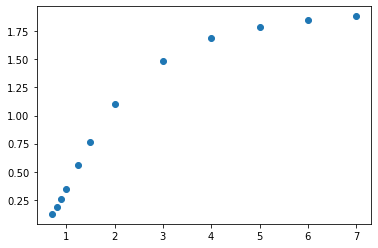

In [65]:
plt.scatter(temps, char_df['C'])

### ferromagnetic 

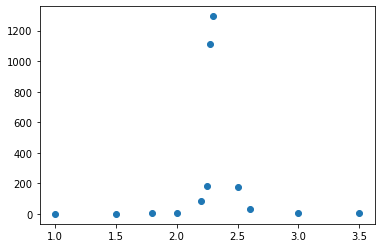

In [358]:
temp = np.array([1, 1.5, 1.8, 2, 2.2, 2.25, 2.27, 2.3, 2.5, 2.6, 3, 3.5])
tau = np.array([0.99824405, 1.24013707, 3.87455095, 8.88365412, 83.95509624, 184.0874894, 1112.24625119, 1293.45461192, 176.15564308, 34.62297555, 8.54602628, 4.09455078])

plt.scatter(temp, tau)

temps = [1, 1.5, 1.8, 2, 2.2, 2.25, 2.3, 2.6, 3, 3.5]
char_df = pd.DataFrame()
for i in temps:
    char_df = pd.concat([char_df, pd.Series(observables(100, 100, i))], axis=1)
    
char_df.columns = temps
char_df = char_df.T
char_df.columns = ['E', 'M', 'C', 'Chi']